In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from torch import Tensor

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

## Architecture

In [2]:
class Generator(nn.Module):
    def __init__(self,
                 latent_space : int = 100,
                ) -> None:
        super(Generator, self).__init__()
    
        def block(in_channels : int, out_channels : int, batch_norm : bool = True):
            layers = [nn.Linear(in_channels, out_channels)]
            if batch_norm:
                layers.append(nn.BatchNorm1d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace = True))
            return layers

        # Layers
        self.layers = nn.Sequential(
            *block(latent_space, 128, batch_norm = False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),

            # outputs : channels * image_size * image_size
            nn.Linear(1024, 1 * 28 * 28),
            nn.Tanh()
        )
    
    def forward(self, x : Tensor) -> Tensor:
        out = self.layers(x)
        out = out.reshape(out.size(0), 1, 28, 28)
        return out

In [3]:
class Discriminator(nn.Module):
    def __init__(self,
                ) -> None:
        super(Discriminator, self).__init__()
        
        self.layers = nn.Sequential(
            # input : channels * image size * image size
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x : Tensor) -> Tensor:
        out = torch.flatten(x, 1)
        out = self.layers(out)
        return out

## Utils

In [4]:
def build_model(latent_space : int = 100):
    generator = Generator(latent_space).to(args.device)
    discriminator = Discriminator().to(args.device)
    
    return generator, discriminator

def load_dataset(batch_size : int) -> Dataset :
    os.makedirs("./data/mnist", exist_ok = True)
    dataloader = DataLoader(
        datasets.MNIST("./data/mnist",
                       train = True,
                       transform = transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize([0.5,],[0.5,]),
                       ]),
                       download = True,),
    batch_size = batch_size,
    shuffle = True,)
    
    return dataloader

def loss_function() -> Tensor:
    adversarial_loss = nn.BCELoss().to(args.device)
    
    return adversarial_loss
    
def optimizer(generator, discriminator, lr : float, b1 : float, b2 : float):
    optimizer_g = optim.Adam(generator.parameters(), lr = args.lr, betas = (b1, b2))
    optimizer_d = optim.Adam(discriminator.parameters(), lr = args.lr, betas = (b1, b2))
    
    return optimizer_g, optimizer_d

## Trainer

In [5]:
def trainer(loader, generator, discriminator,optimizer_g, optimizer_d,loss_fn, args) -> None:
    """ Training Generative Adversarial Networks """
    
    # list to keep track of progress
    g_losses = []
    d_losses = []
    img_list = []
    iters = 0
    start = datetime.now()
    
    # set model in training model
    generator.train()
    discriminator.train()
    

    
    for epoch in range(1, args.epochs):
        for index, (real, _) in enumerate(loader):
            #flatten
            real = real.view(-1, 784).to(args.device)
            size = real.size(0)
            # create ground truth. set real sample level to 1 and fake sample level to 0
            real_sample = torch.full([size, 1], 1.0, dtype=real.dtype, device=args.device)
            fake_sample = torch.full([size, 1], 0.0, dtype=real.dtype, device=args.device)
            
            # create a noise sample for generator input
            noise = torch.randn([size, args.latent_space], device = args.device)
            
            """ Train Discriminator"""
            # initialize discriminator model gradients
            discriminator.zero_grad()
            # calculate loss of discriminator model on real images
            output = discriminator(real)
            loss_real_d = loss_fn(output, real_sample)
            # calculate gradient of discriminator in backward pass
            loss_real_d.backward()
            D_x = output.mean().item()
            
            # generate fake image
            fake = generator(noise)
            # calculate loss of discriminator model on fake images
            output = discriminator(fake.detach())
            loss_fake_d = loss_fn(output, fake_sample)
            # calculate gradient of discriminator for this batch summed with previous gradient
            loss_fake_d.backward()
            D_G_z1 = output.mean().item()
            # calculate loss of discriminator model as sum on both real images and fake images
            loss_d = loss_real_d + loss_fake_d
            # update weight of discriminator model
            optimizer_d.step()
            
            """ Train Generator """
            # initialize generator model gradient
            generator.zero_grad()
            # calculate the loss of discriminator model on fake images
            output = discriminator(fake)
            loss_g = loss_fn(output, real_sample)
            # calculate gradient of generator
            loss_g.backward()
            D_G_z2 = output.mean().item()
            # update weight of generator model
            optimizer_g.step()
            
            # save images to see training stability
            if index == 0:
                vutils.save_image(vutils.make_grid(fake.detach().cpu().view(-1, *(1, 28, 28)), normalize = True), os.path.join(args.outputs_dir, f"fake_image_{epoch}.jpg"))
                vutils.save_image(vutils.make_grid(real.detach().cpu().view(-1, *(1, 28, 28)), normalize = True), os.path.join(args.outputs_dir, f"real_image_{epoch}.jpg"))
                
            # Print the loss function every ten iterations and the last iteration in this epoch.
            if index % 10 == 0 or index == len(loader):
                print(f"Train stage: adversarial "
                      f"Epoch[{epoch:04d}/{args.epochs:04d}]({index:05d}/{len(loader):05d}) "
                      f"D Loss: {loss_d.item():.6f} G Loss: {loss_g.item():.6f} "
                      f"D(D_x): {D_x:.6f} D(D_G_z1)/D(D_G_z2): {D_G_z1:.6f}/{D_G_z2:.6f}.")
            
            # save losses for plotting later
            g_losses.append(loss_g.item())
            d_losses.append(loss_d.item())
            
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == args.epochs) and (i == len(dataloader))):
                with torch.no_grad():
                    fake = generator(noise)
                # append in img_list to plot
                img_list.append(vutils.make_grid(fake.detach().cpu().view(-1, *(1 ,28, 28)), padding=2, normalize=True))
                # save generated image under number of iteration name
                vutils.save_image(vutils.make_grid(fake.detach().cpu().view(-1, *(1 ,28, 28))), os.path.join(args.outputs_dir, f"iters_{iters}.jpg"))

            iters += 1
            
            
        
        if epoch % 10 == 0:
            # Save the weight of discriminator and generator model under number of epoch name
            torch.save(discriminator.state_dict(), os.path.join(args.outputs_dir, f"d_epoch{epoch}.pth"))
            torch.save(generator.state_dict(), os.path.join(args.outputs_dir, f"g_epoch{epoch}.pth"))
        
            
        print("Training complete in: " + str(datetime.now() - start))
    
    # Save final weight of discriminator and generator model
    torch.save(discriminator.state_dict(), os.path.join(args.outputs_dir, f"final_d.pth"))
    torch.save(generator.state_dict(), os.path.join(args.outputs_dir, f"final_g.pth"))
        
    return g_losses, d_losses, img_list

## Configurations

In [6]:
class ARGS():
    outputs_dir = 'output'
    latent_space = 100
    batch_size = 64
    epochs = 50
    b1 = 0.5
    b2 = 0.9
    lr = 0.002
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    outputs_dir = os.path.join(outputs_dir,  "GAN")
    if not os.path.exists(outputs_dir):
        os.makedirs(outputs_dir)
    
    seed = 42
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # for the current configuration, so as to optimize the operation efficiency.
    cudnn.benchmark = True
    # Ensure that every time the same input returns the same result.
    cudnn.deterministic = True
    
args = ARGS()

## Main

In [7]:
def main(args):
    loader = load_dataset(args.batch_size)
    print('Loaded dataset successfully')
    generator, discriminator = build_model(args.latent_space)
    print('Built model successfully')
    loss_fn = loss_function()
    print('Define loss function succesfully')
    optimizer_g, optimizer_d = optimizer(generator, discriminator,args.lr, args.b1, args.b2)
    print('Define all optimization function successfully')
    
    # training
    g_losses, d_losses, img_list = trainer(loader, generator, discriminator, optimizer_g, optimizer_d, loss_fn, args)
    
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(g_losses,label="G")
    plt.plot(d_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

    HTML(ani.to_jshtml())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Loaded dataset successfully
Built model successfully
Define loss function succesfully
Define all optimization function successfully
Train stage: adversarial Epoch[0001/0050](00000/00938) D Loss: 1.413072 G Loss: 0.699072 D(D_x): 0.495156 D(D_G_z1)/D(D_G_z2): 0.508266/0.497304.
Train stage: adversarial Epoch[0001/0050](00010/00938) D Loss: 1.580938 G Loss: 1.068140 D(D_x): 0.915046 D(D_G_z1)/D(D_G_z2): 0.760412/0.386325.
Train stage: adversarial Epoch[0001/0050](00020/00938) D Loss: 1.129337 G Loss: 2.051646 D(D_x): 0.743919 D(D_G_z1)/D(D_G_z2): 0.556439/0.167635.
Train stage: adversarial Epoch[0001/0050](00030/00938) D Loss: 1.023138 G Loss: 1.113239 D(D_x): 0.614268 D(D_G_z1)/D(D_G_z2): 0.394191/0.353891.
Train stage: adversarial Epoch[0001/0050](00040/00938) D Loss: 1.248136 G Loss: 0.282513 D(D_x): 0.416038 D(D_G_z1)/D(D_G_z2): 0.277912/0.762733.
Train stage: adversarial Epoch[0001/0050](00050/009

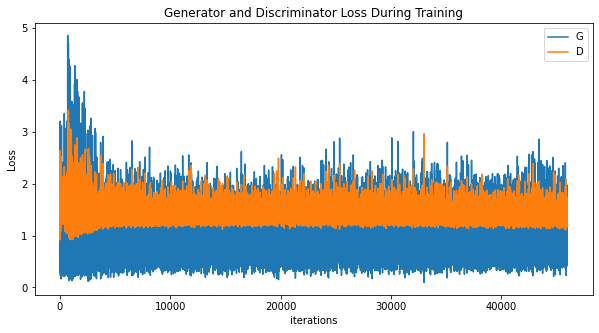

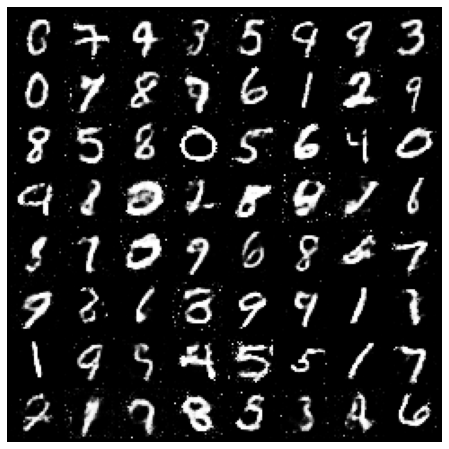

In [8]:
if __name__ == "__main__":
    main(args)

In [9]:
!zip -r file.zip ./output

  adding: output/ (stored 0%)
  adding: output/GAN/ (stored 0%)
  adding: output/GAN/real_image_9.jpg (deflated 2%)
  adding: output/GAN/fake_image_40.jpg (deflated 1%)
  adding: output/GAN/iters_16000.jpg (deflated 2%)
  adding: output/GAN/real_image_39.jpg (deflated 2%)
  adding: output/GAN/fake_image_14.jpg (deflated 1%)
  adding: output/GAN/real_image_28.jpg (deflated 2%)
  adding: output/GAN/iters_9500.jpg (deflated 1%)
  adding: output/GAN/final_g.pth (deflated 7%)
  adding: output/GAN/real_image_45.jpg (deflated 2%)
  adding: output/GAN/iters_15000.jpg (deflated 2%)
  adding: output/GAN/fake_image_41.jpg (deflated 1%)
  adding: output/GAN/iters_3500.jpg (deflated 1%)
  adding: output/GAN/d_epoch20.pth (deflated 7%)
  adding: output/GAN/real_image_20.jpg (deflated 2%)
  adding: output/GAN/fake_image_48.jpg (deflated 1%)
  adding: output/GAN/iters_0.jpg (deflated 1%)
  adding: output/GAN/real_image_49.jpg (deflated 2%)
  adding: output/GAN/fake_image_47.jpg (deflated 1%)
  adding: